# Part 1: Initial data preparation

In [8]:
# import required packages
import pandas as pd
# !pip install pandas fiona shapely pyproj rtree
!pip install pandas fiona shapely pyproj rtree
!pip install geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
!pip install rasterio
import rasterio
from rasterio.plot import show
import os
import numpy as np
from shapely.geometry import LineString
from shapely.ops import unary_union

In [9]:
# these are survey data streamlines
jsonfiles = os.listdir('../data/Cienega/wetdry/survey_data')

In [10]:
# import data files
geodata = {f:0 for f in jsonfiles}
for f in jsonfiles:
  print(f)
  df = gpd.read_file('https://raw.githubusercontent.com/lapidesd/'+
                     'SanPedro_wetdry_pilot/main/data/Cienega/wetdry/survey_data/'+f).to_crs('EPSG:26912')
  geodata[f] = df

# wetted channel surveys
surveylist = [geodata[key] for key in jsonfiles]

# get geomorphic channel points for surveyed reach every 5 m
survey_boundary = gpd.read_file('https://raw.githubusercontent.com/lapidesd/'+
                     'SanPedro_wetdry_pilot/main/data/Cienega/surveyReach.geojson').to_crs('EPSG:26912')
survey_boundary_geom = survey_boundary['geometry'].unary_union
distance_delta = 5 # point every 5 m along line
distances = np.arange(0,survey_boundary_geom.length, distance_delta)
points = [survey_boundary_geom.interpolate(distance) for distance in distances]+[survey_boundary_geom.boundary.geoms[-1]]
# multipoint = unary_union(points)
geomorph = gpd.GeoDataFrame(pd.DataFrame.from_dict({'p':[0]*len(points)}),geometry=points).set_crs('EPSG:26912')

6-25-2004.geojson
9-8-2022.geojson
12-12-2012.geojson
3-10-2023.geojson
12-16-2016.geojson
9-16-2008.geojson
6-17-2010.geojson
6-13-2014.geojson
6-23-2005.geojson
6-11-2009.geojson
6-8-2023.geojson
3-31-2011.geojson
9-19-2017.geojson
6-3-2016.geojson
3-3-2004.geojson
6-26-2001.geojson
3-23-2018.geojson
3-25-2010.geojson
12-23-2011.geojson
3-13-2012.geojson
6-7-2019.geojson
12-14-2010.geojson
6-3-2022.geojson
6-12-2020.geojson
12-13-2019.geojson
9-23-2016.geojson
9-17-2003.geojson
9-28-2005.geojson
12-9-2008.geojson
9-9-2006.geojson
3-18-2008.geojson
3-16-2017.geojson
3-22-2002.geojson
12-4-2013.geojson
6-15-2007.geojson
6-9-2021.geojson
12-21-2005.geojson
12-19-2003.geojson
3-25-2003.geojson
12-14-2001.geojson
6-1-2000.geojson
6-9-2017.geojson
9-10-2021.geojson
12-18-2007.geojson
12-9-2015.geojson
3-27-2013.geojson
6-5-2018.geojson
12-22-2004.geojson
3-24-2020.geojson
12-18-2020.geojson
12-12-2014.geojson
3-18-2022.geojson
6-12-2013.geojson
9-27-2007.geojson
12-17-2018.geojson
9-18-200

# DO NOT RUN THIS::Put together a dataset of nodes with PlanetScope data
This cannot be run in Colab (would take days), and PlanetScope data is not available in the data supplement

In [4]:
# get list of imagery rasters available
imagery_location = '../../Cienega/data/Imagery/PSScene/'
rasters = os.listdir(imagery_location)
rasters = [r for r in rasters if r.endswith('SR_clip.tif')]

In [5]:
# function to extract PlanetScope zonal stats in buffer (buffer=True)
# around geomorphic channel
# or at geomorphic channel point (buffer=False)
def query_raster(x,y, # GPS point
                 point1, # GPS point (geometry type)
                 raster, # satellite imagery
                 buffer): # buffer area (# pixels) around channel point to grab data from
    r = raster
    band_data = {'blue':0,
                   'geometry':0,
                   'green':0,
                   'red':0,
                  #  'rededge':0,
                   'NIR':0,
                #  'Yellow':0,
                #  'GreenI':0,
                #  'CoastalBlue':0,
                 'missing':0}
    missing = 0
    row, col = r.index(x,y) # find location of the gps point (x,y) in the raster image
    if buffer:
      rs = list(range(row-1,row+2))
      cs = list(range(col-1,col+2))
    else:
      rs = [row]
      cs = [col]
    try:
      blues = []
      greens = []
      reds = []
      # rededges = []
      nirs = []
      for row in rs:
        for col in cs:
          blues.append(raster.read(1)[row,col])
          greens.append(raster.read(2)[row,col])
          reds.append(raster.read(3)[row,col])
          # rededges.append(raster.read(4)[row,col])
          nirs.append(raster.read(4)[row,col])

      band_data['blue'] = np.nanmean(blues)
      band_data['geometry'] = point1
      band_data['green'] = np.nanmean(greens)
      band_data['red'] = np.nanmean(reds)
      # band_data['rededge'] = np.nanmean(rededges)
      band_data['NIR'] = np.nanmean(nirs)
    except:
      missing = 1
    band_data['missing'] = missing
    return (band_data)

In [ ]:
# very slow in colab--ran on local machine

# gdfs = []
!pip install multiprocess
gdf = geomorph
gdf['x'] = gdf.to_crs('EPSG:26912').geometry.x
gdf['y'] = gdf.to_crs('EPSG:26912').geometry.y
import rasterio
def query_buffer(args):
    cpu,cpus,rasters = args
    for i in range(int(cpu/cpus*len(rasters)),int((cpu+1)/cpus*len(rasters))): # separate rasters onto separate cores
        r1 = rasters[i]
        #   print(i,'of',len(rasters))
        date = r1.split('_')[0]
        r = rasterio.open(imagery_location+r1)
        out = gdf.apply(lambda row:query_raster(row.x,row.y,row.geometry,
                                                                     r,buffer = True),axis=1)
        keys = list(out.values[0].keys())
        # try:
        band_data = pd.DataFrame.from_dict({keys[j]:[out.values[i][keys[j]] for i in range(len(out))]
                              for j in range(len(keys))})

        # return (band_data)
        band_data = band_data[band_data.missing==0]
        band_data = gpd.GeoDataFrame(
          band_data, geometry=band_data.geometry).set_crs('EPSG:26912')
        band_data['NDWI'] = (band_data.green-band_data.NIR)/(band_data.green+band_data.NIR)
        g = gpd.sjoin(band_data,gdf,how='left')
        g = g.drop_duplicates().drop(columns='index_right')
        g['date'] = date
        g.to_file('../../Cienega/data/Imagery/buffer/'+r1[:-4]+'.tif')
        # except:
        #     print('no geoms for',r1)
    return

import multiprocess as mp
import sys


cores = 8
import time
start_time = time.time()
sys.stdout.write('\r\n')
arguments = []
for cpu in range(0,cores):
    arguments.append((cpu,cores,rasters))
pool = mp.Pool()
results = pool.map(query_buffer, arguments)

# r = query_buffer(arguments[0])
extime = time.time()-start_time
print(extime)

/Users/danalapides/miniconda3/lib/python3.11/site-packages/geopandas/io/file.py:572: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)
/Users/danalapides/miniconda3/lib/python3.11/site-packages/geopandas/io/file.py:572: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)
/Users/danalapides/miniconda3/lib/python3.11/site-packages/geopandas/io/file.py:572: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)
/Users/danalapides/miniconda3/lib/python3.11/site-packages/geopandas/io/file.py:572: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_fi

In [12]:
gdfs = []
for i in range(len(rasters)):
    r = rasters[i]
    print(i,' of',len(rasters))
    try:
        g = gpd.read_file('../../Cienega/data/Imagery/buffer/'+r[:-4]+'.tif/'+r[:-4]+'.shp')
        gdfs.append(g)
    except:
        print('skipping '+r)
gdf_predict = pd.concat(gdfs)

0  of 4310
1  of 4310
2  of 4310
3  of 4310
4  of 4310
5  of 4310
6  of 4310
7  of 4310
8  of 4310
9  of 4310
10  of 4310
11  of 4310
12  of 4310
13  of 4310
14  of 4310
15  of 4310
16  of 4310
17  of 4310
18  of 4310
19  of 4310
20  of 4310
21  of 4310
22  of 4310
23  of 4310
24  of 4310
25  of 4310
26  of 4310
27  of 4310
28  of 4310
29  of 4310
30  of 4310
31  of 4310
32  of 4310
33  of 4310
34  of 4310
35  of 4310
36  of 4310
37  of 4310
38  of 4310
39  of 4310
40  of 4310
41  of 4310
42  of 4310
43  of 4310
44  of 4310
45  of 4310
46  of 4310
47  of 4310
48  of 4310
49  of 4310
50  of 4310
51  of 4310
52  of 4310
53  of 4310
54  of 4310
55  of 4310
56  of 4310
57  of 4310
58  of 4310
59  of 4310
60  of 4310
61  of 4310
62  of 4310
63  of 4310
64  of 4310
65  of 4310
66  of 4310
67  of 4310
68  of 4310
69  of 4310
70  of 4310
71  of 4310
72  of 4310
73  of 4310
74  of 4310
75  of 4310
76  of 4310
77  of 4310
78  of 4310
79  of 4310
80  of 4310
81  of 4310
82  of 4310
83  of 4310
84

In [15]:
start = 0
splitnum = 40
for i in range(1,splitnum+1):
    newstart = int(len(gdf_predict)/splitnum*i)
    gdf_predict.iloc[start:newstart].drop(columns=['x','y']).to_csv('../data/Cienega/processed_imagery/PSScope_data_buffer_'+str(i)+'.csv',index=False,
                      float_format='%.2f')
    start = newstart

In [ ]:
# gdfs = []
# for i in range(len(rasters)):
#     r = rasters[i]
#     print(i,' of',len(rasters))
#     g = gpd.read_file('buffer_data1/'+r[:-4]+'.tif/'+r[:-4]+'.shp')
#     gdfs.append(g)

In [ ]:
# gdf_predict['x'] = gdf_predict.geometry.x
# gdf_predict['y'] = gdf_predict.geometry.y
# gdf_predict.to_csv('buffer_data/rapideye_predict_data_buffer.csv')

# Put together a dataset for training the random forest model

In [83]:
import shapely
surveyloc = '../data/Cienega/wetdry/survey_data/'
surveyfiles = os.listdir(surveyloc)
surveyed = []
for f in surveyfiles:
    s = gpd.read_file(surveyloc+f)
    
    if (s.crs=='WGS 84'):
        # print(f)
        s = s.set_crs('ESRI:102649',allow_override=True)
    s = s.to_crs('EPSG:26912')
    s['date'] = f.split('.')[0]
    surveyed.append(s)
surveyed = pd.concat(surveyed)
wet = surveyed[['date','geometry']]
wet['wetdry'] = 'wet'
surveyed = gpd.read_file('../data/Cienega/surveyReach.geojson').to_crs('EPSG:26912')
surveyyr = surveyed.geometry.unary_union

drysegments = []
for y in wet['date'].unique():
    wetyr = wet[wet['date']==y].geometry.unary_union
    dryyr = surveyyr.difference(shapely.buffer(wetyr,.1))
    drysegments.append(dryyr)
dry = pd.DataFrame.from_dict({'date':wet.date.unique(),
                              'geometry':drysegments})
dry = gpd.GeoDataFrame(dry,geometry=dry.geometry)
dry['wetdry'] = 'dry'
wetdry = pd.concat([wet,dry])

/Users/danalapides/miniconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/danalapides/miniconda3/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/danalapides/miniconda3/lib/python3.11/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)
/Users/danalapides/miniconda3/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/danalapides/miniconda3/lib/python3.11/site-packages/shapely/constructive.

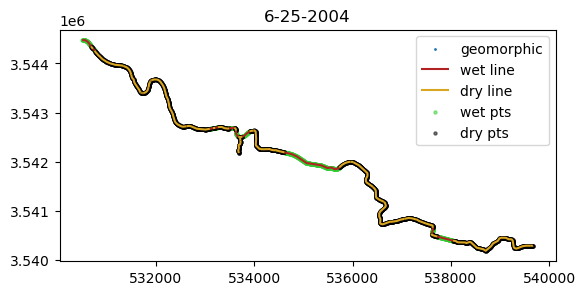

/Users/danalapides/miniconda3/lib/python3.11/site-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


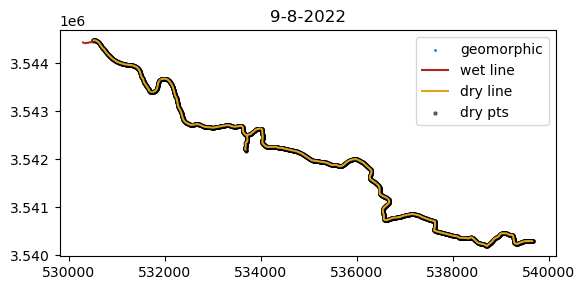

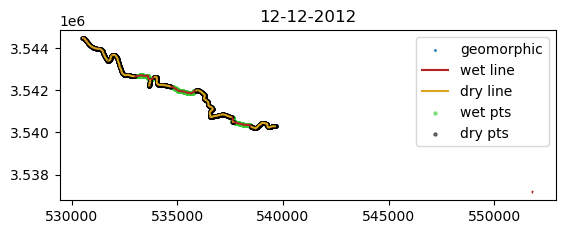

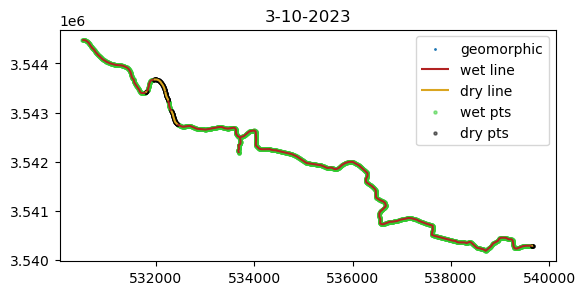

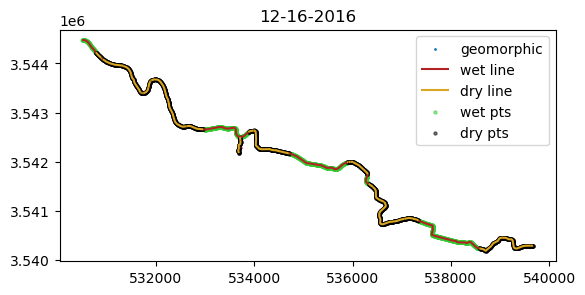

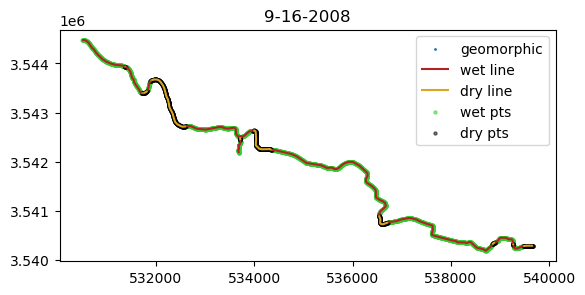

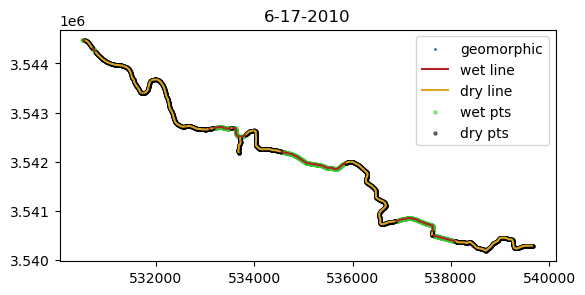

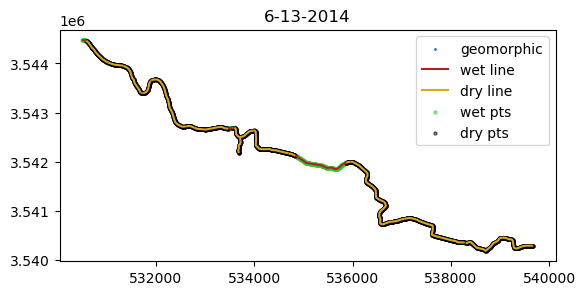

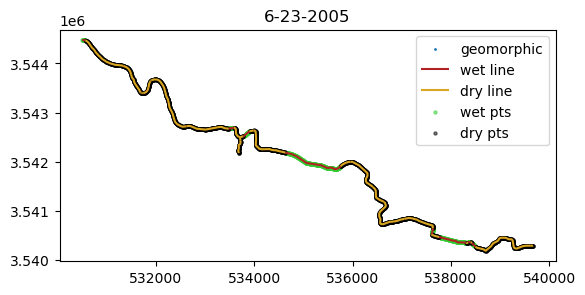

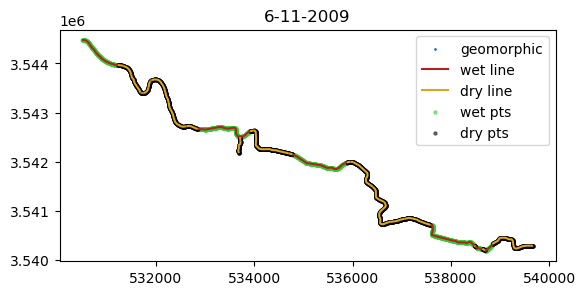

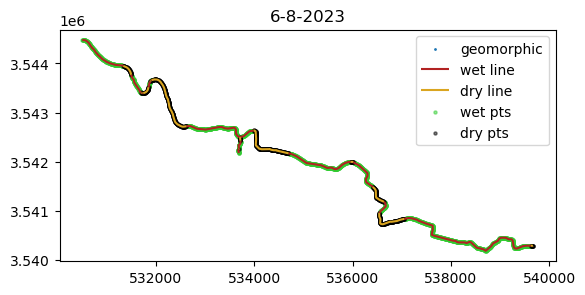

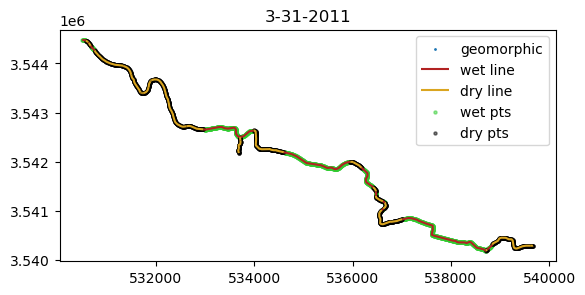

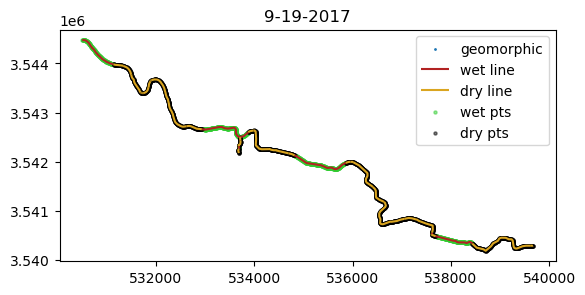

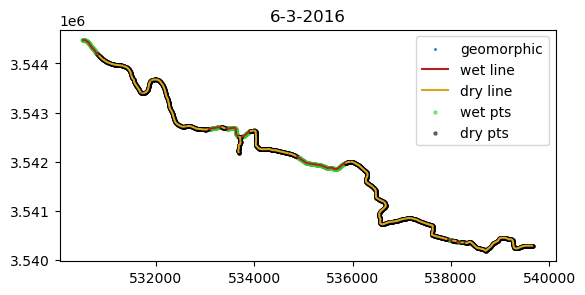

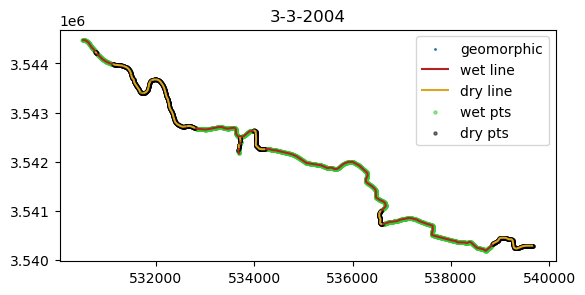

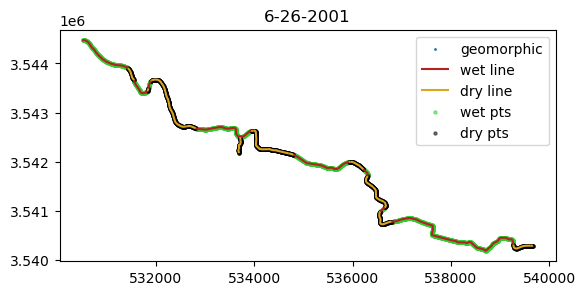

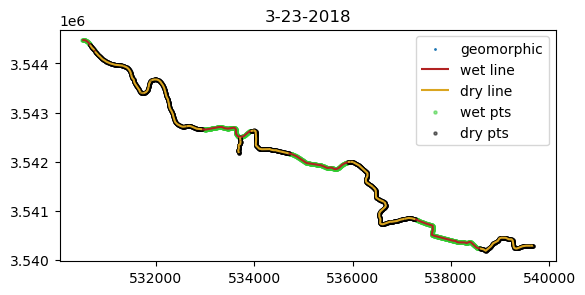

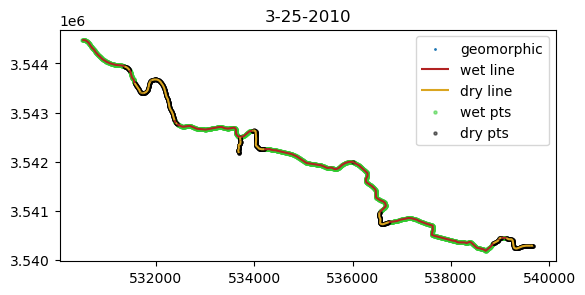

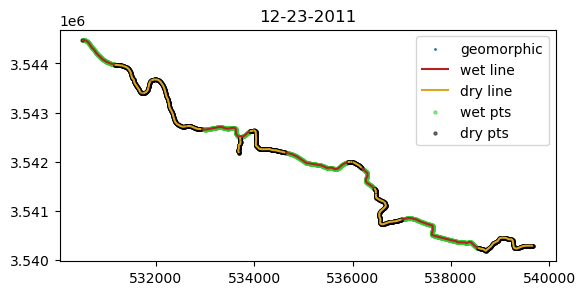

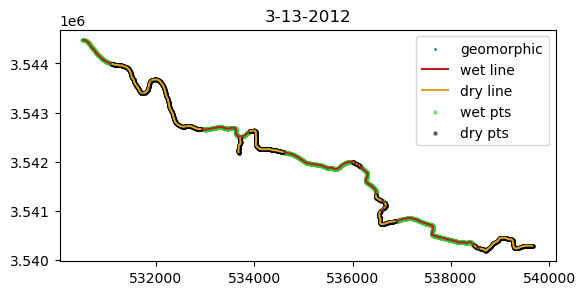

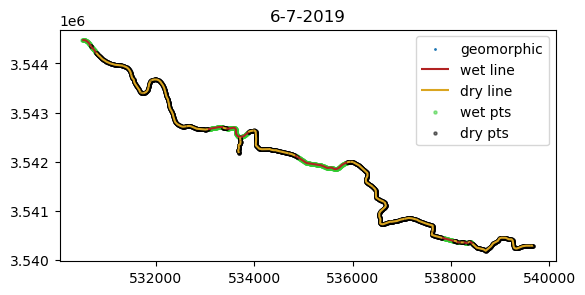

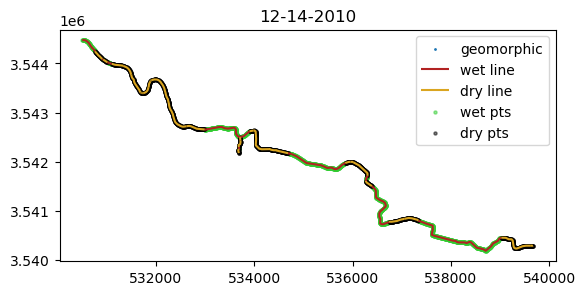

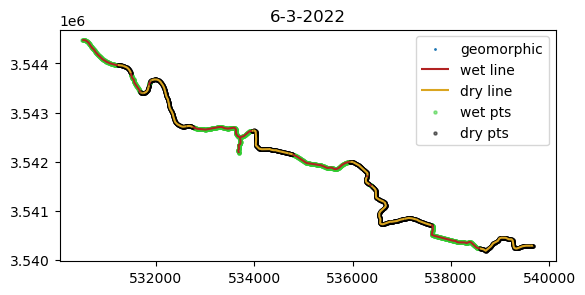

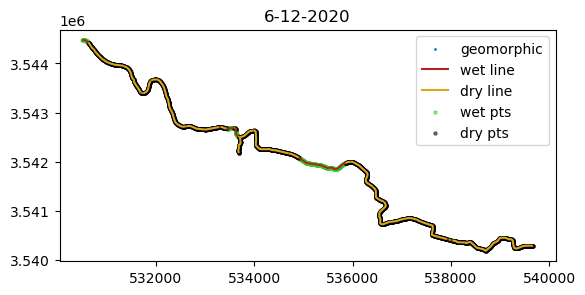

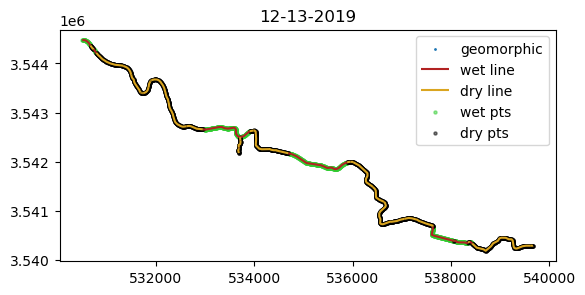

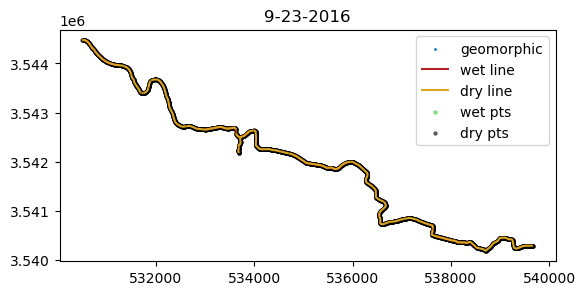

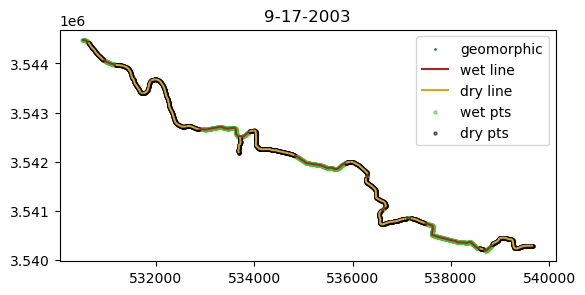

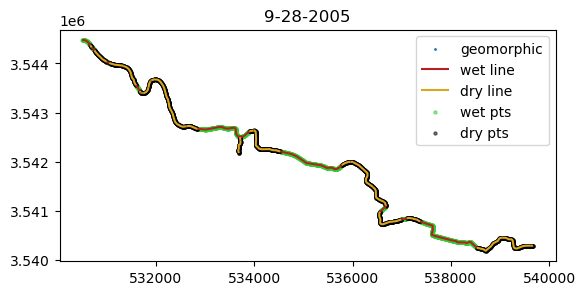

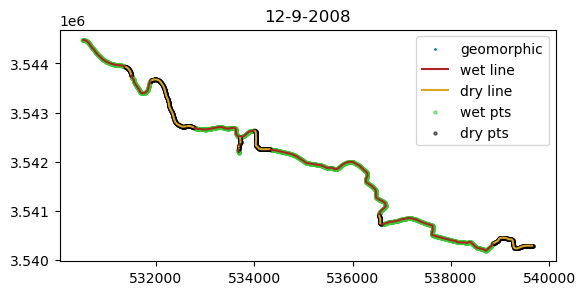

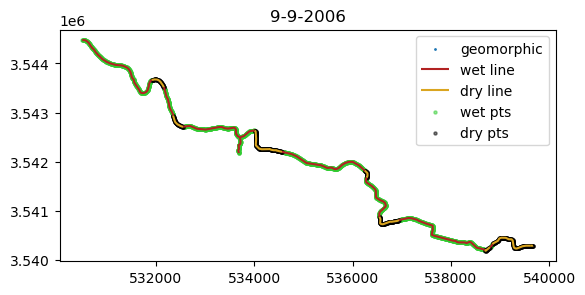

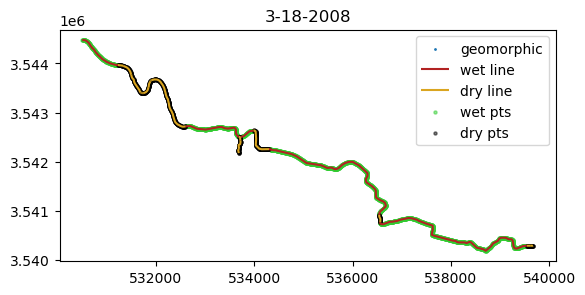

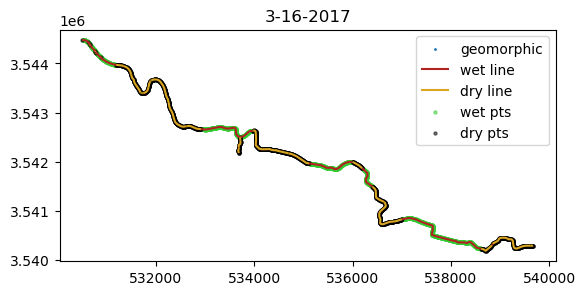

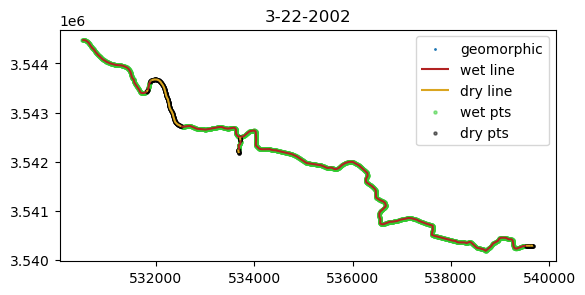

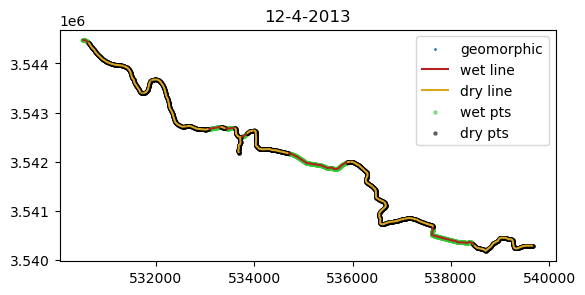

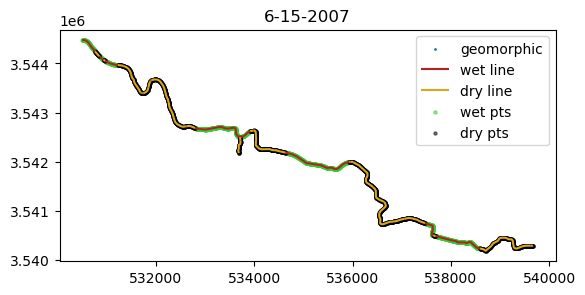

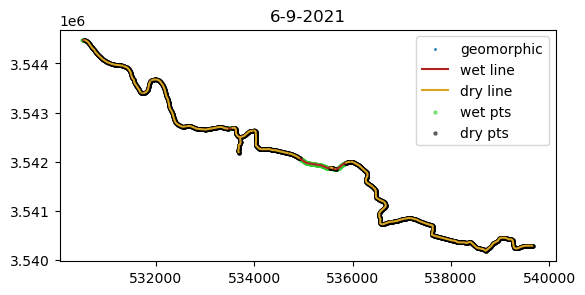

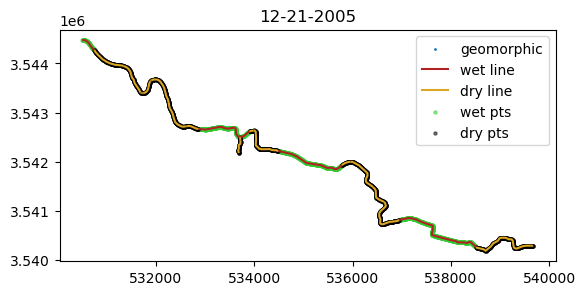

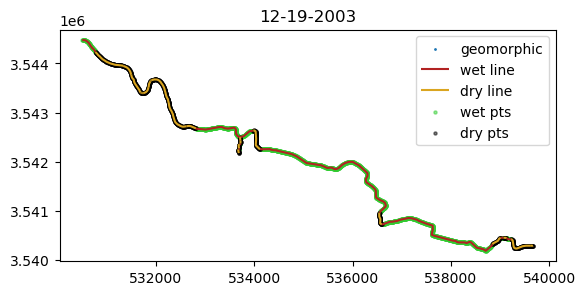

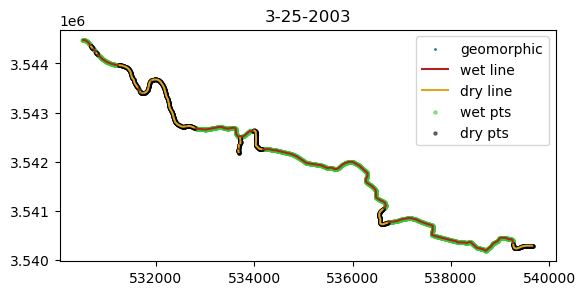

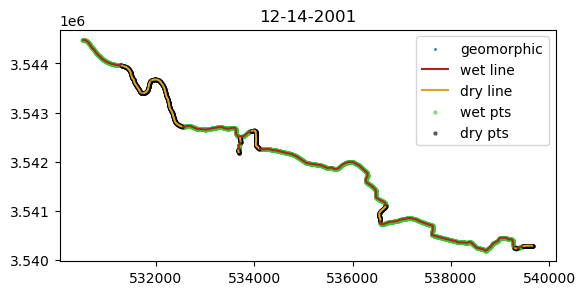

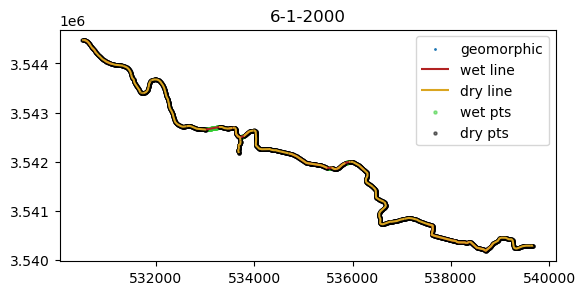

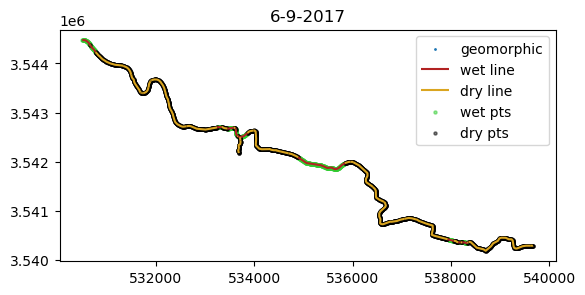

/Users/danalapides/miniconda3/lib/python3.11/site-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


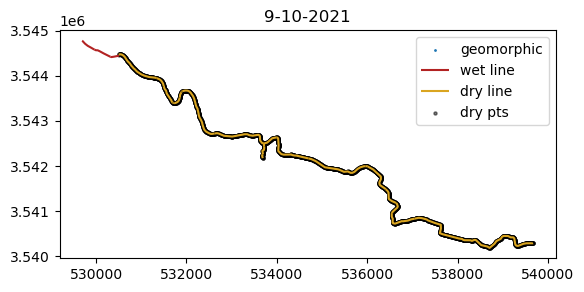

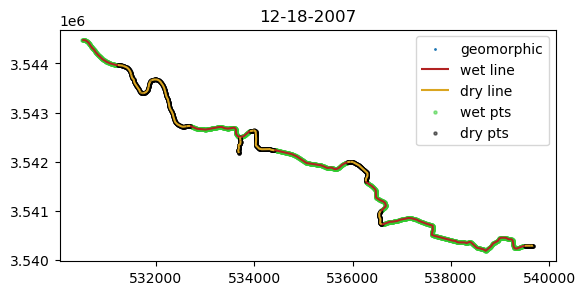

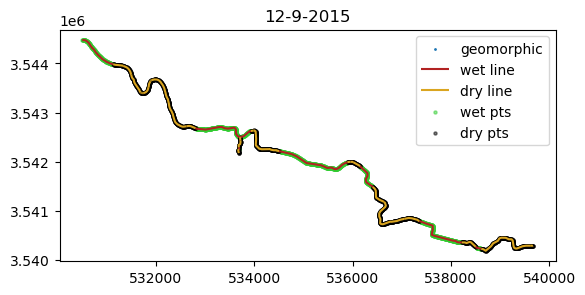

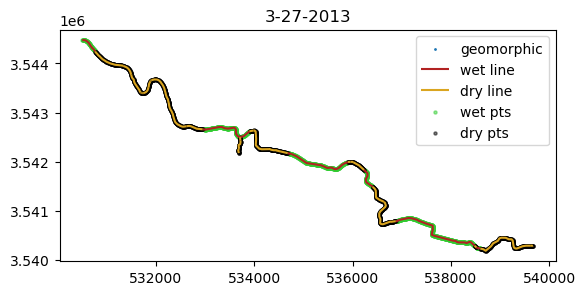

/Users/danalapides/miniconda3/lib/python3.11/site-packages/geopandas/plotting.py:417: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  warnings.warn(
/Users/danalapides/miniconda3/lib/python3.11/site-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


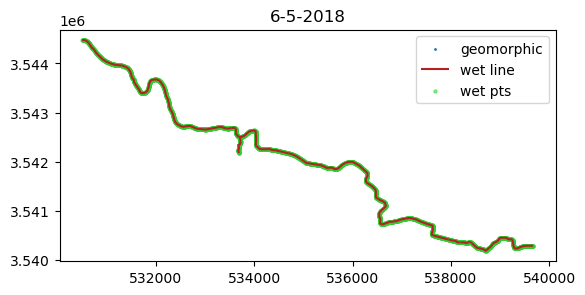

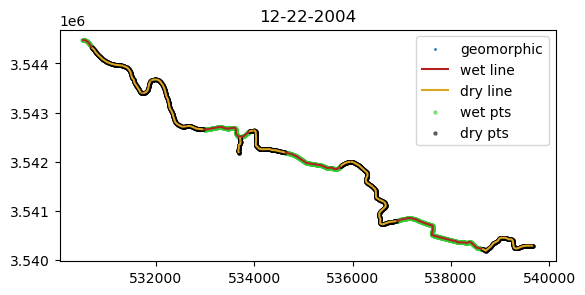

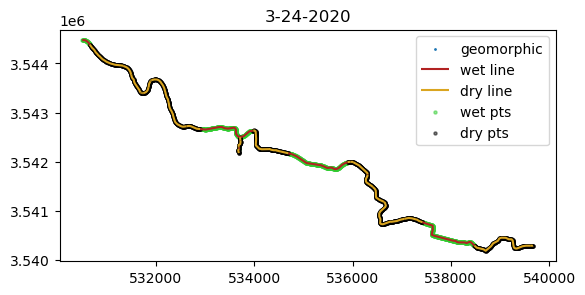

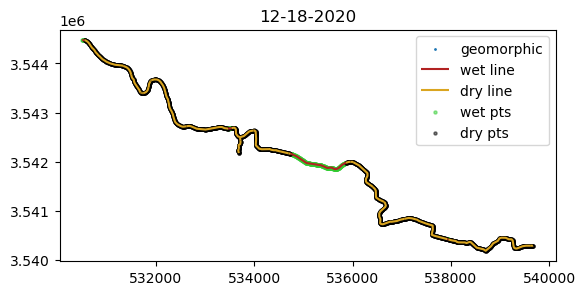

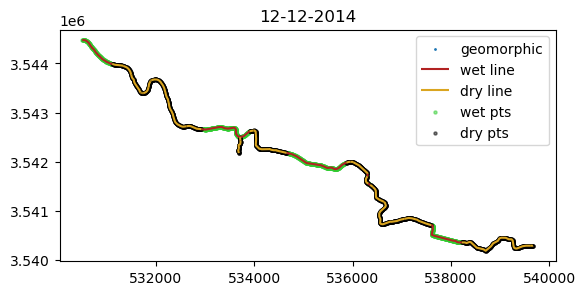

/Users/danalapides/miniconda3/lib/python3.11/site-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


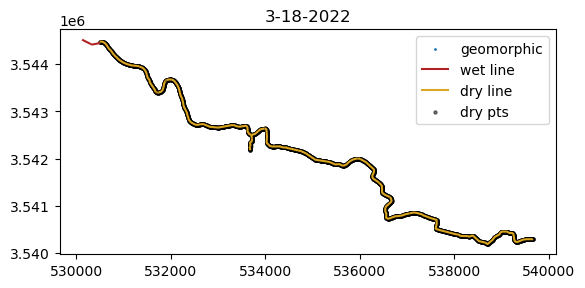

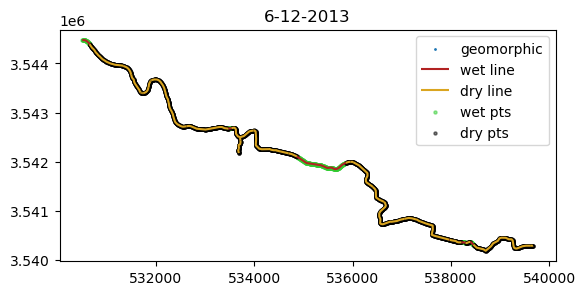

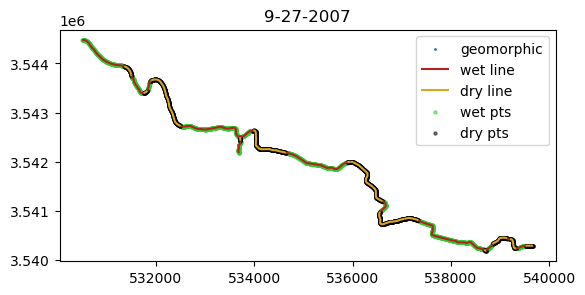

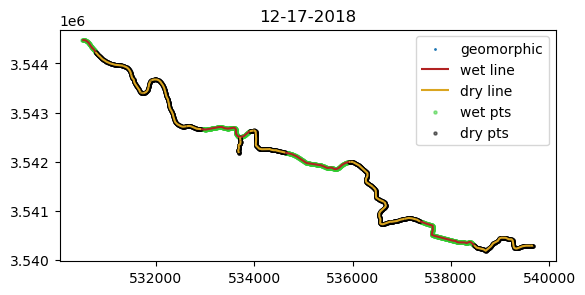

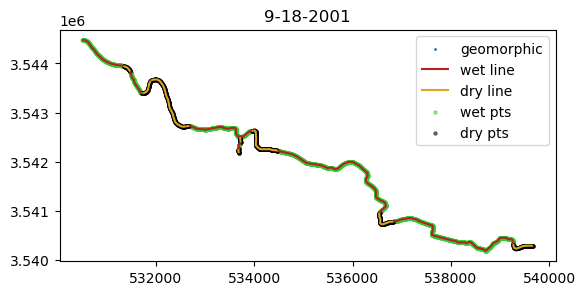

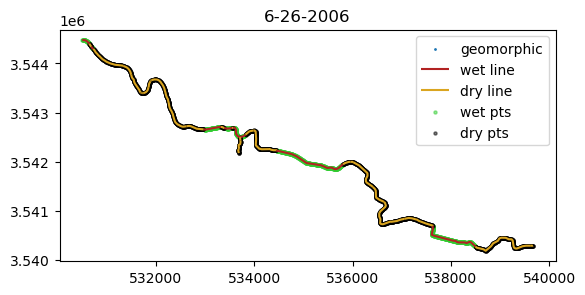

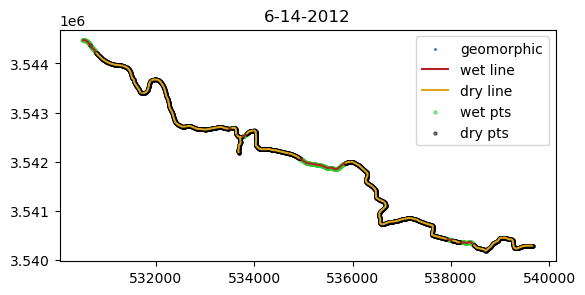

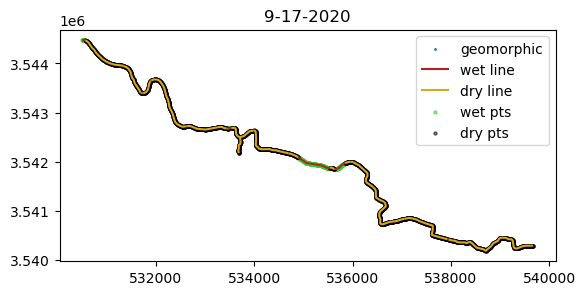

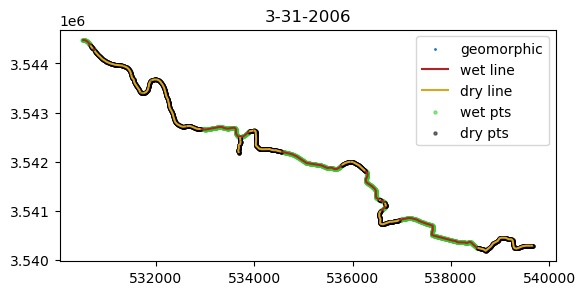

/Users/danalapides/miniconda3/lib/python3.11/site-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


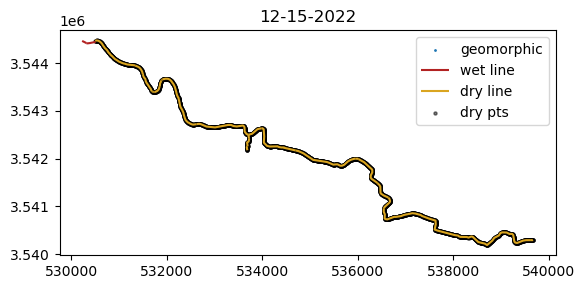

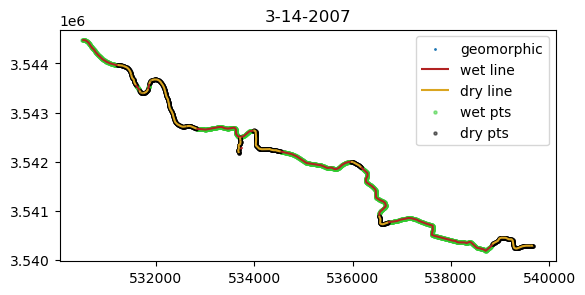

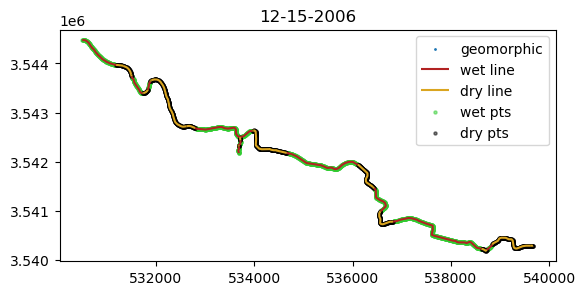

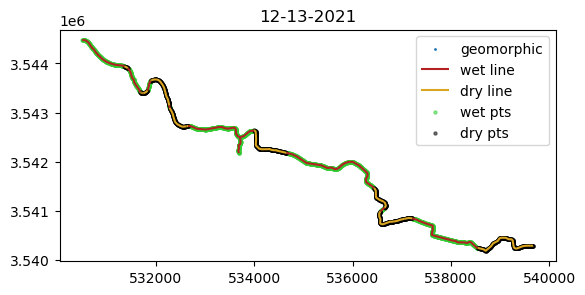

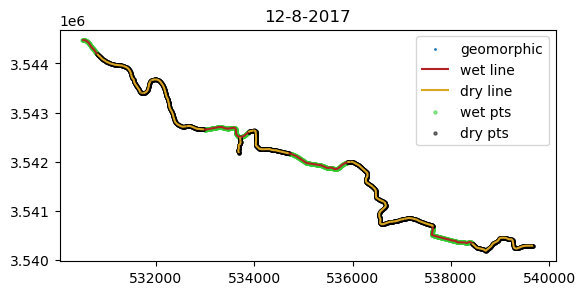

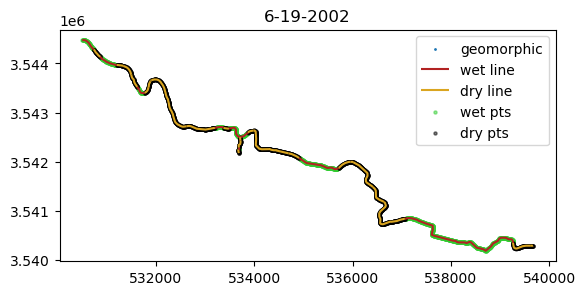

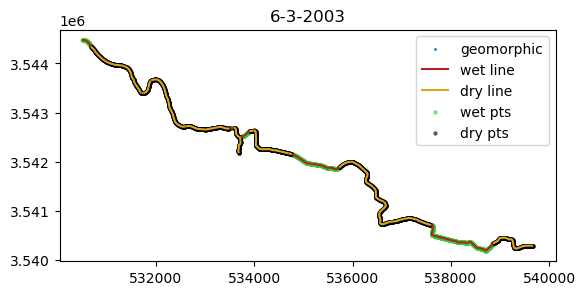

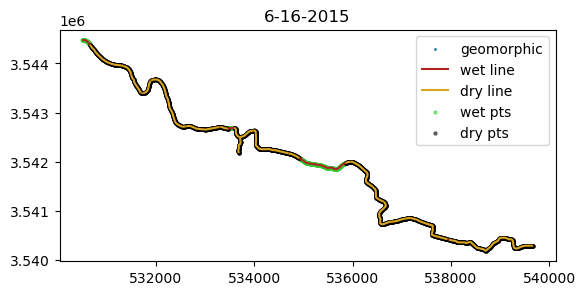

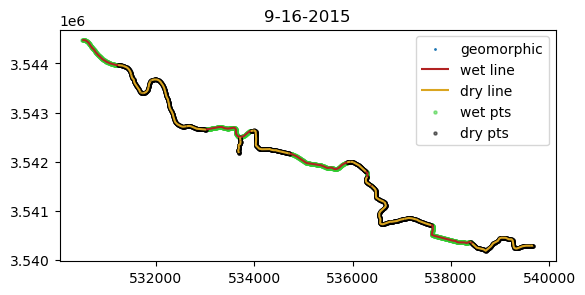

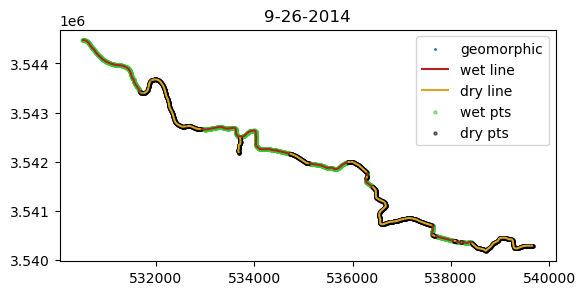

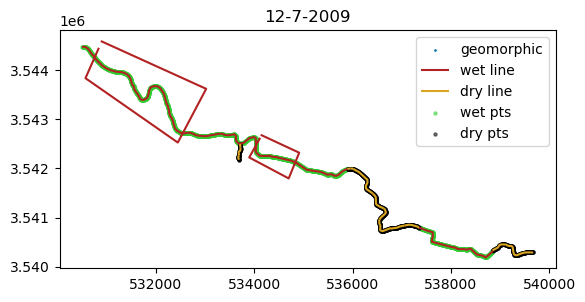

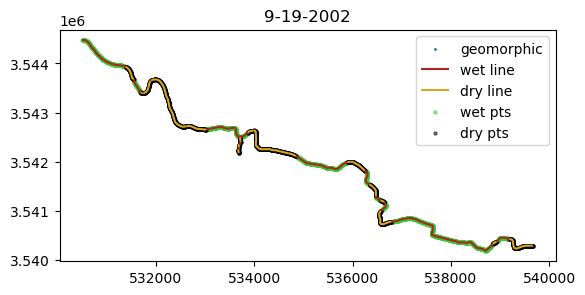

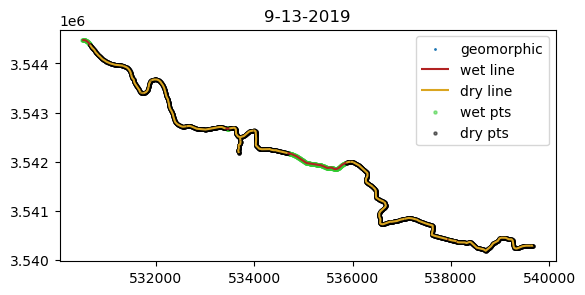

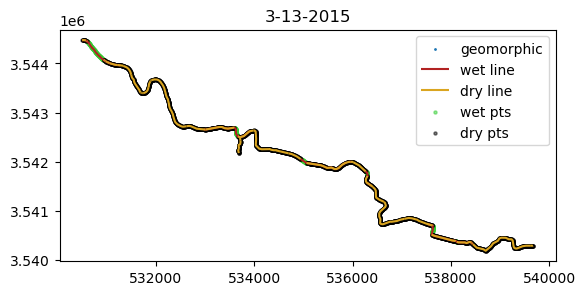

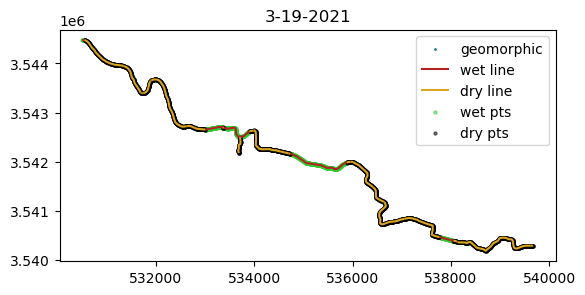

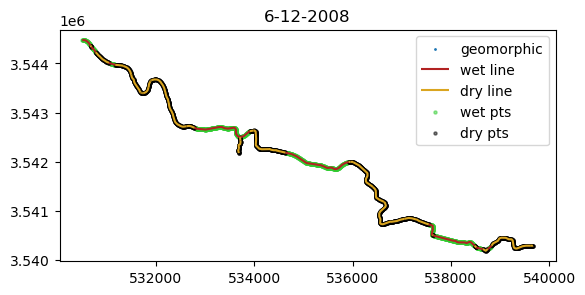

/Users/danalapides/miniconda3/lib/python3.11/site-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


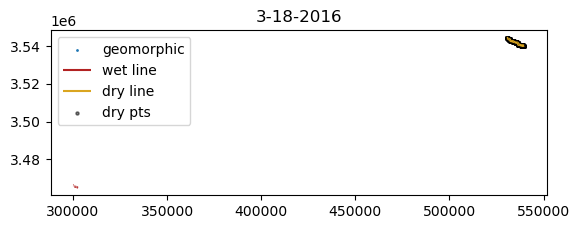

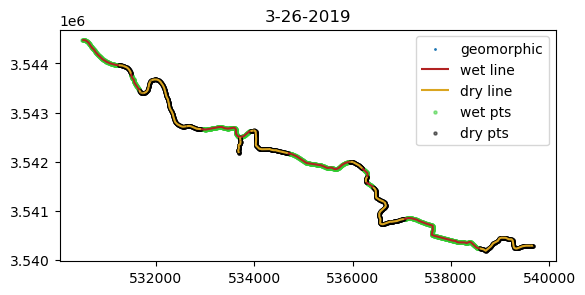

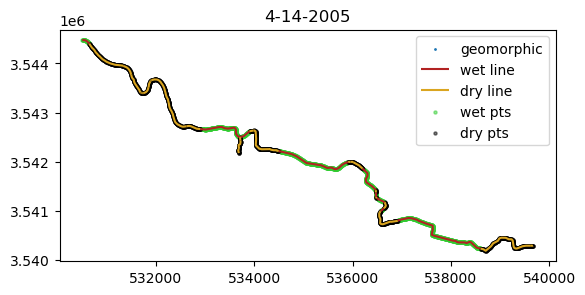

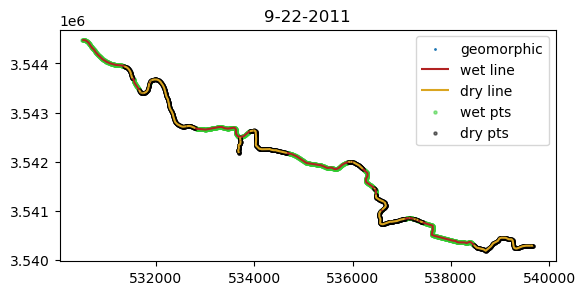

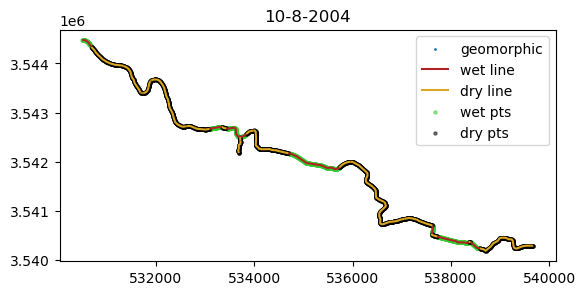

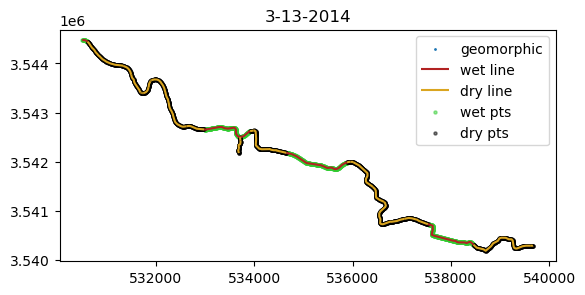

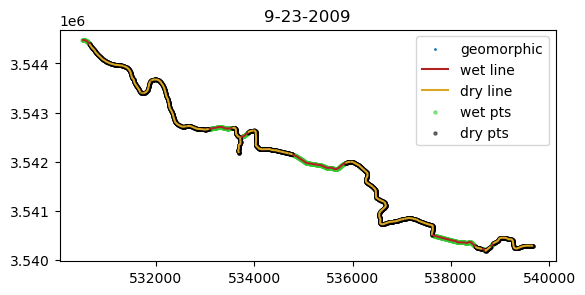

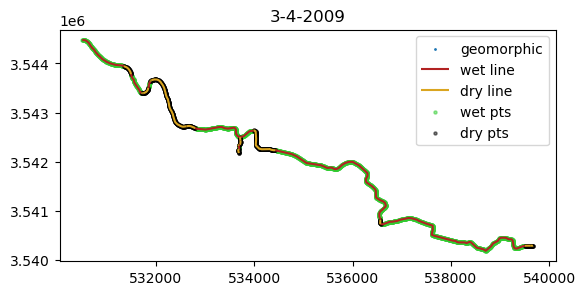

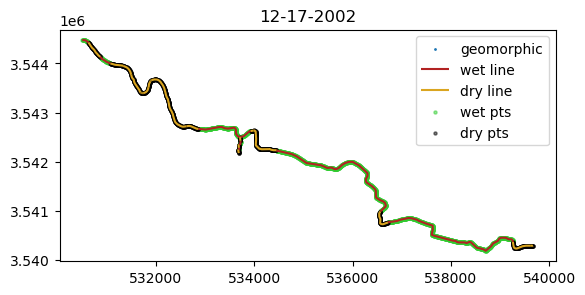

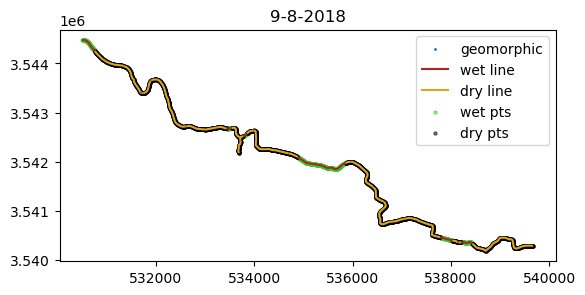

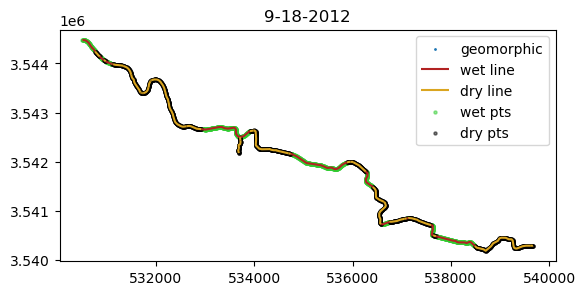

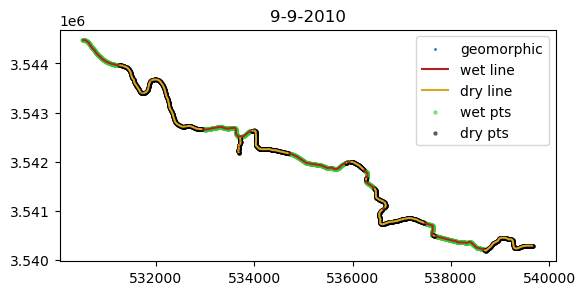

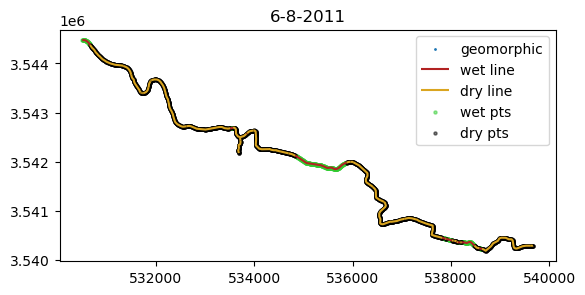

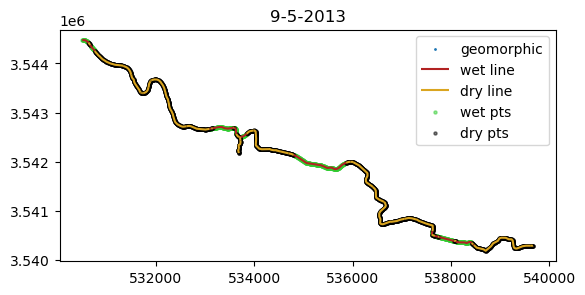

In [84]:
d = 1 # m, max distance for error in merge-->this is too big
surveyData = []

for y in wetdry.date.unique()[:]:
    wsub = wetdry[(wetdry.date==y) ].to_crs('EPSG:26912')
    wetpts = gpd.sjoin_nearest(geomorph, wsub, max_distance=d,)
    wetpts['Year'] = y
    surveyData.append(wetpts)
    drypts = wetpts[wetpts.wetdry=='dry']
    wetpts = wetpts[wetpts.wetdry=='wet']
    # drypts = gpd.sjoin_nearest(geomorph, dsub, max_distance = d)
    fig,ax = plt.subplots(1)
    geomorph.plot(ax=ax,markersize=1,label='geomorphic')
    wsub[wsub.wetdry=='wet'].plot(edgecolor = 'firebrick',ax=ax,label='wet line')
    wsub[wsub.wetdry=='dry'].plot(edgecolor = 'goldenrod',ax=ax,label='dry line')
    wetpts.plot(ax=ax,c='limegreen',markersize = 5,label='wet pts',alpha=.5)
    drypts.plot(ax=ax,c='k',markersize = 5, label='dry pts',alpha=.5)
    ax.legend()
    ax.set_title(y)
    plt.show()

surveyData =pd.concat(surveyData)[['geometry','Year','wetdry']]

In [ ]:
# next steps

# goal: import satellite spectra information into the surveyData dataframe

# add x, y columns to surveyData for merging

# use Agnes's csv to find the imagery date to get data from for each row
# merge into surveyData so we have an imagery date in each row--merge on survey date only

# before this block, read in all of the imagery data into one dataframe (../data/Cienega/processed_imagery)
# (read in a loop, concatenate together)

# merge imagery data into surveyData given imagery date--mergey on geometry and imagery date

# at the end of this block, you have training data for survey dates

In [ ]:
# change these symbols for Cienega Creek data

# 0 dry
# 1 flowing
# 2 possibly wet, unobserved
# 3 likely wet, not observed round 1
# 4 wet, stagnant

wetsymbols1 = [1,2,3,4,5] # list of symbols that mean wet

# if point is assigned to wet and dry, assume wet

# find points marked as wet during survey R1
surveyR1 = pd.concat([geodata['Streamchannels_R1_2015_'+key] for key in
                      ['Rock.geojson','Hank.geojson','Dry.geojson','Confluence.geojson']])
# surveyR1wet = surveyR1[surveyR1.moisture.isin(wetsymbols1)]
surveyR1['geometry'] = surveyR1.buffer(1.5)
R1_wet = gpd.sjoin(gdf,surveyR1.to_crs('EPSG:4326')).drop(columns=['Length',])
gdf1 = gpd.sjoin(R1_wet[['geometry','Moisture']],gdf,how='right').fillna(0)
gdf1['wet'] = np.where(gdf1.Moisture.isin(wetsymbols1),1,0)
gdf1 = gdf1.drop_duplicates()
gdf1['wet'] = np.where(gdf1.drop(columns=['wet','Moisture']).duplicated(keep=False),1,gdf1.wet)
gdf1 = gdf1[~(gdf1.drop(columns=['Moisture','wet']).duplicated(keep='first'))]
gdf1.drop(columns=['index_left','Moisture'],inplace=True)
# Date of nearest RapidEye image
gdf1['date'] = pd.to_datetime('2015-06-04')


# find points marked as wet during survey R2
surveyR2 = pd.concat([geodata['Streamchannels_R2_2015_'+key] for key in
                      ['Rock.geojson','Hank.geojson','Dry.geojson','Confluence.geojson']])
# surveyR2wet = surveyR2[surveyR2.moisture.isin(wetsymbols2)]
surveyR2['geometry'] = surveyR2.buffer(1.5)
R2_wet = gpd.sjoin(gdf,surveyR2.to_crs('EPSG:4326')).drop(columns=['Length',])
gdf2 = gpd.sjoin(R2_wet[['geometry','Moisture']],gdf1,how='right').fillna(0)
gdf2['wet'] = np.where(gdf2.Moisture.isin(wetsymbols2),1,0)
gdf2 = gdf2.drop_duplicates()
gdf2['wet'] = np.where(gdf2.drop(columns=['wet','Moisture']).duplicated(keep=False),1,gdf2.wet)
gdf2 = gdf2[~(gdf2.drop(columns=['Moisture','wet']).duplicated(keep='first'))]
gdf2.drop(columns=['index_left','Moisture'],inplace=True)

# Date of nearest RapidEye image
gdf2['date'] = pd.to_datetime('2015-08-22')



/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [ ]:
testing = []
for i in range(11):
  testing.append(pd.read_csv('https://raw.githubusercontent.com/lapidesd/'+
                                 'wetted_channels_from_space/main/Data/'+
                                 'predict_data_'+str(i)+'.csv'))
testing = pd.concat(testing)

In [ ]:
gdf1 = gdf1.drop(columns=['date','geometry']).merge(testing[testing.date=='2015-06-04'],left_on=['x','y'],
           right_on=['x','y']).drop_duplicates()

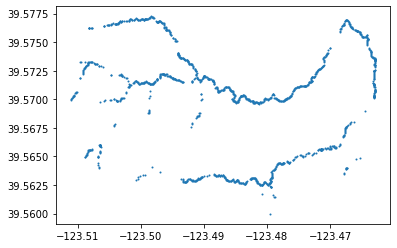

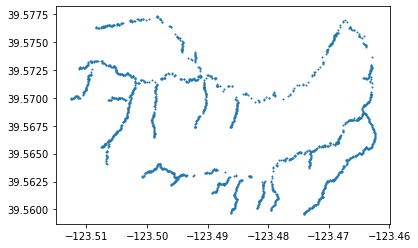

In [ ]:
g1 = gdf1[(gdf1['wet']==1)&(gdf1.area_updated>100000)]
g2 = gdf1[(gdf1['wet']==0)&(gdf1.area_updated>100000)]
plt.scatter(g1.x,g1.y,s=1)
plt.show()
plt.scatter(g2.x,g2.y,s=1
            )

In [ ]:
gdf2 = gdf2.drop(columns=['date','geometry']).merge(testing[testing.date=='2015-08-22'],left_on=['x','y'],
                  right_on=['x','y'])

In [ ]:
gdf3 = testing[testing.date=='2019-10-31']
gdf['wet'] = 0

In [ ]:
gdf4 = testing[testing.date=='2016-03-23']
gdf['wet'] = 1

In [ ]:
gdf5 = testing[testing.date=='2016-03-07']
gdf['wet'] = 1

In [ ]:
gdf6 = testing[testing.date=='2017-01-24']
gdf['wet'] = 1

In [ ]:
gdf_all = pd.concat([gdf1,gdf2,gdf3,gdf4,gdf5,gdf6]).drop(columns=['accum [m2]']).rename(
                                                         columns={'datetime_x':'datetime',
                                                                  'slope_percent_x':'slope_percent'}).fillna(0)
gdf_all.to_csv('/content/drive/MyDrive/Sky_Data/combined_data_buffer.csv')

# Part 2: processing initial data

In [ ]:
# # save original training data to github small size
# # keep this block

# training1 = training.drop(columns=['Unnamed: 0','Lithology_'])
# len2 = int(len(training1)/2)+2
# for i in range(2):
#   training1.iloc[len2*i:len2*(i+1)+1].to_csv('temporary_training_'+str(i)+'.csv',index=False)

In [ ]:
testing = []
for i in range(11):
  testing.append(pd.read_csv('https://raw.githubusercontent.com/lapidesd/'+
                                 'wetted_channels_from_space/main/Data/'+
                                 'predict_data_'+str(i)+'.csv'))
testing = pd.concat(testing)
testing = testing[~(testing.date.isin(testing))]

training = []
for i in range(2):
  training.append(pd.read_csv('https://raw.githubusercontent.com/lapidesd/'+
                              'wetted_channels_from_space/main/Data/'+
                              'temporary_training_'+str(i)+'.csv'))
training = pd.concat(training)

In [ ]:
newarea = pd.read_csv('https://raw.githubusercontent.com/lapidesd/'+
                      'wetted_channels_from_space/main/Data/'+
                      'geomorphic_pts_newarea%202.csv')[['x','y','area_updated','slope_percent']]


In [ ]:
# add an extra day to the training data (done date)
# no longer relevant since using larger channels only

new_data = testing[testing.date=='2018-02-12']
new_data = new_data[new_data['area_updated']<20000]
new_data['wet'] = 0
new_training = pd.concat([training,new_data])

new_training = new_training.drop_duplicates()

# # save data
# new_training.to_csv('/content/drive/MyDrive/Sky_Data/combined_data_buffer1.csv',index=False)

Add in more training data

In [ ]:
!pip install hydrofunctions
import hydrofunctions as hf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 40 kB 3.7 MB/s 
     |████████████████████████████████| 1.6 MB 8.2 MB/s 


In [ ]:
elder = hf.NWIS('11475560',start_date='2015-06-01',end_date='2022-08-01',
                parameterCd = '00060').df().rename(columns={'USGS:11475560:00060:00003':'flow_cfs'})
survey_flow = elder.loc['2015-06-04'].flow_cfs
dates_highflow = [str(t).split('T')[0] for t in elder[elder.flow_cfs>survey_flow*3].index.values]

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=11475560&parameterCd=00060&startDT=2015-06-01&endDT=2022-08-01


In [ ]:
df_test = testing.copy()
df_train = new_training.copy()

In [ ]:
df_test['date'] = pd.to_datetime(df_test.date)
zero_startyr = df_train[(df_train.date=='2015-06-04') &
         (df_train.wet==0)]
forward_test = df_test[(df_test.date>'2015-06-04') &
        (df_test.date<'2015-08-22') &
        (df_test.x.isin(zero_startyr.x.values)) &
        (df_test.y.isin(zero_startyr.y.values))]
forward_test['wet'] = 0
one_endyr = df_train[(df_train.date=='2015-08-22') &
         (df_train.wet==1)]
back_test = df_test[(df_test.date>'2015-06-04') &
        (df_test.date<'2015-08-22') &
        (df_test.x.isin(one_endyr.x.values)) &
        (df_test.y.isin(one_endyr.y.values))]
back_test['wet'] = 1
one_startyr = df_train[(df_train.date=='2015-06-04') &
         (df_train.wet==1)]
backearly_test = df_test[(df_test.date>'2015-03-15') &
        (df_test.date<'2015-06-04') &
        (df_test.x.isin(one_startyr.x.values)) &
        (df_test.y.isin(one_startyr.y.values))]
backearly_test['wet'] = 1
forward_moresummer = df_test[(pd.to_datetime(df_test.date).dt.month.isin([7,8,9,10])) &
                             (df_test.date.dt.year>2016) &
        (df_test.x.isin(zero_startyr.x.values)) &
        (df_test.y.isin(zero_startyr.y.values))]
forward_moresummer['wet'] = 0

# add more training data for wet times
# (elder flow at least 3x elder flow at first survey)
reallywet = df_test[(df_test.date.isin(dates_highflow)) &
                    (df_test.x.isin(one_startyr.x.values)) &
                    (df_test.y.isin(one_startyr.y.values))]
reallywet['wet'] = 1



# concatenate all of the new data
added_data = pd.concat([df_train,back_test,forward_test,backearly_test,
                        forward_moresummer,
                        reallywet
                        ])
added_data = added_data.drop_duplicates()

## fix 3-7-2016
added_data = added_data[added_data.date!='2016-03-07']
add_fixed_date = df_test[(df_test.date=='2016-03-07')]
add_fixed_date['wet'] = 1
added_data = pd.concat([added_data,add_fixed_date])

# # save data
# added_data.to_csv('/content/drive/MyDrive/Sky_Data/rapideye_train_data_buffer_moredata.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

##ADD in a plot off all dates of training data

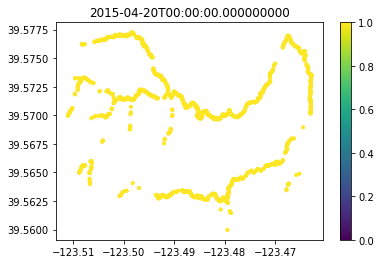

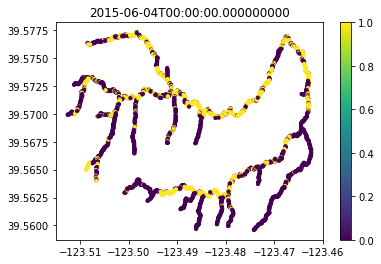

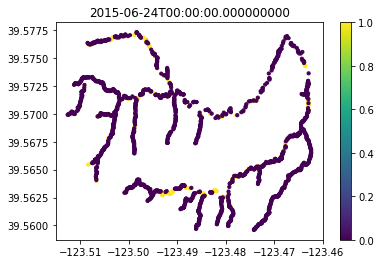

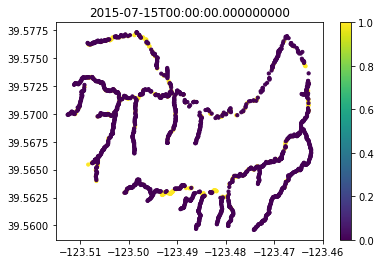

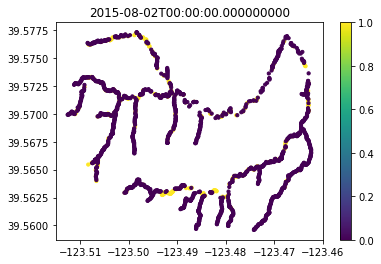

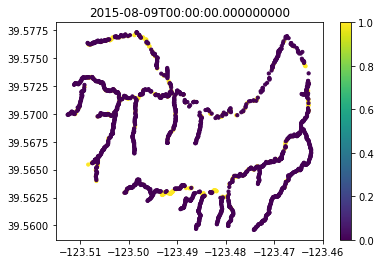

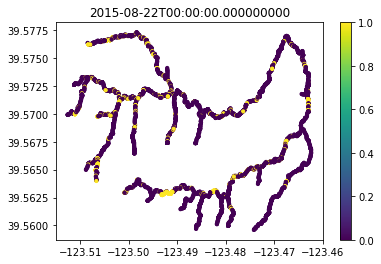

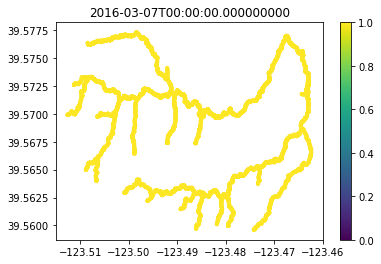

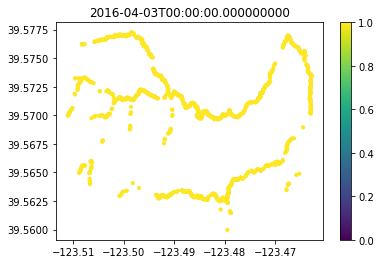

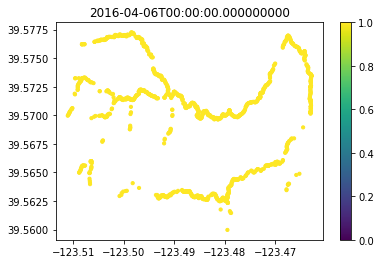

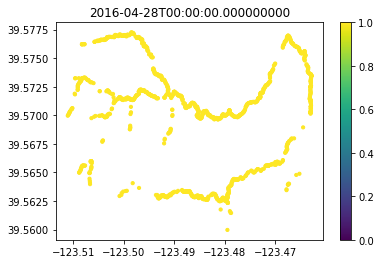

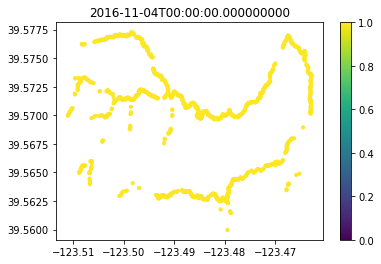

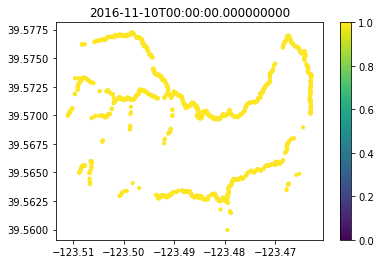

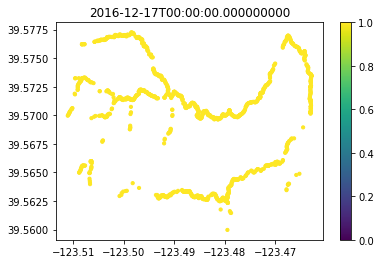

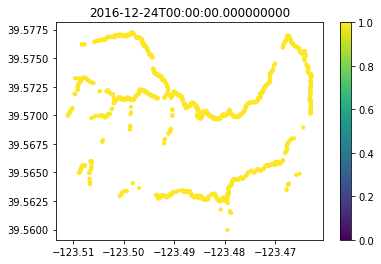

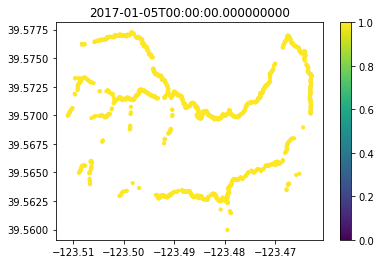

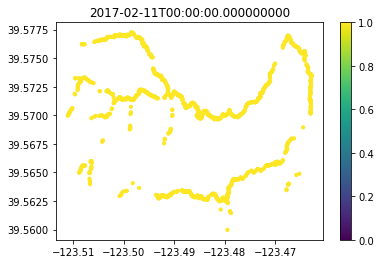

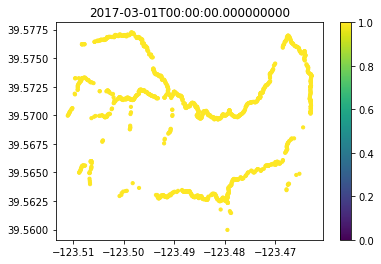

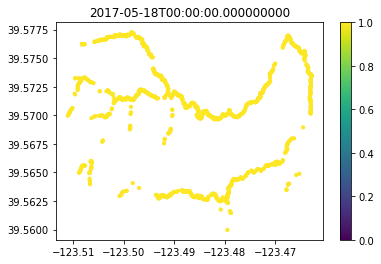

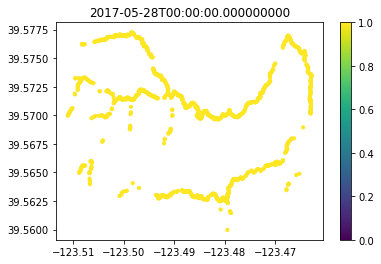

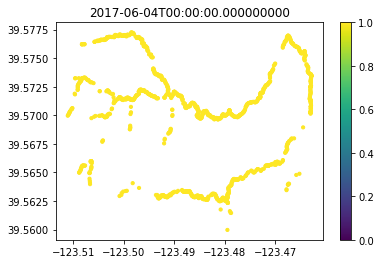

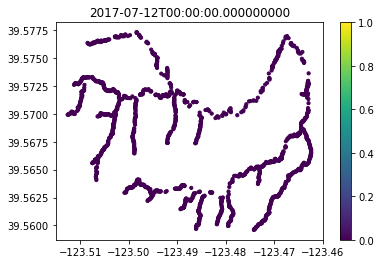

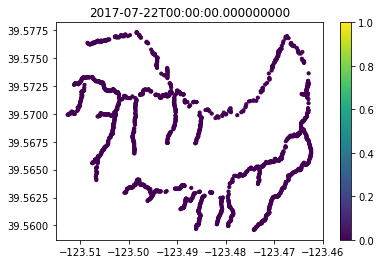

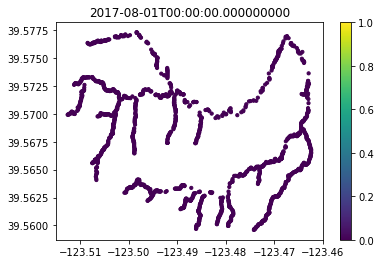

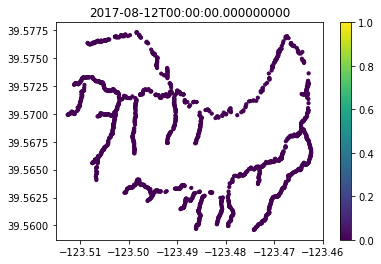

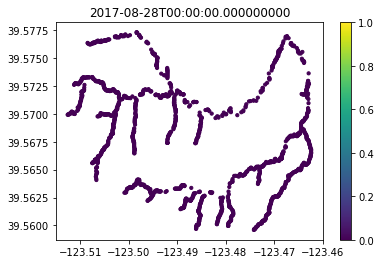

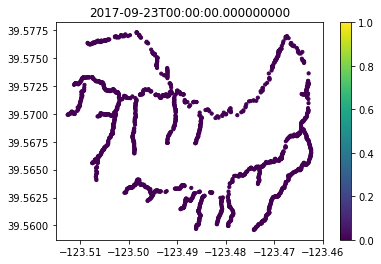

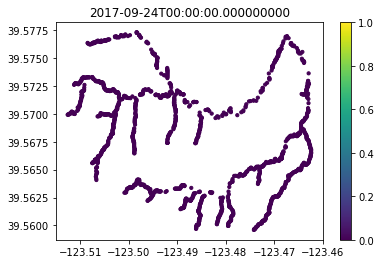

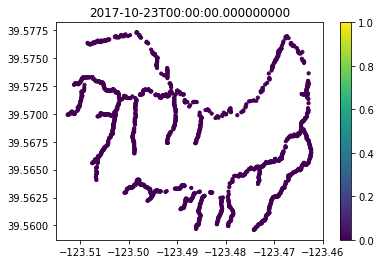

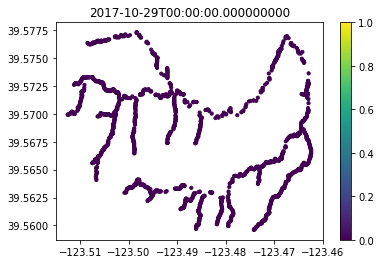

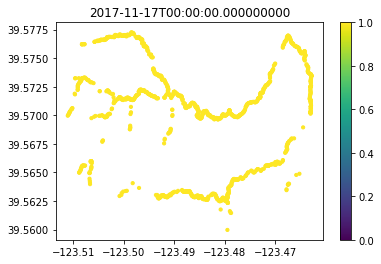

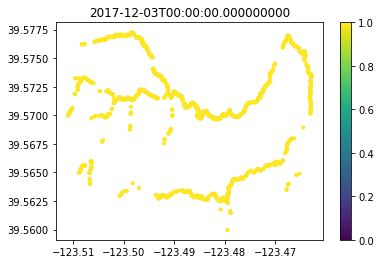

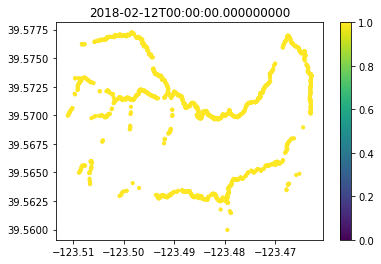

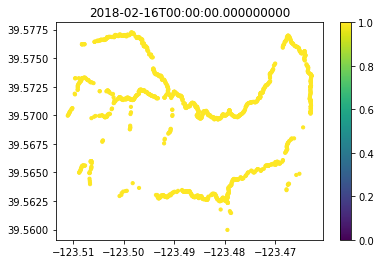

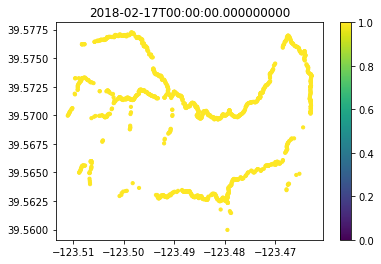

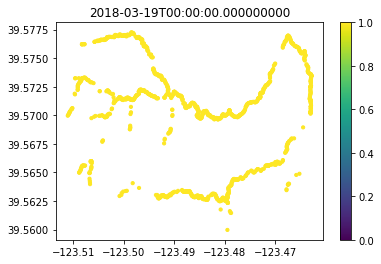

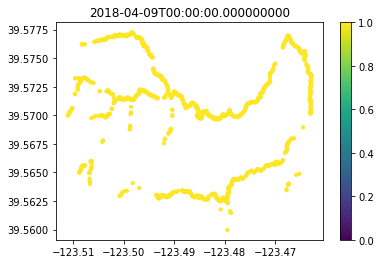

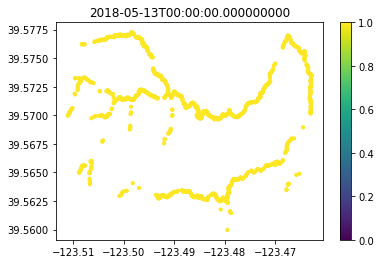

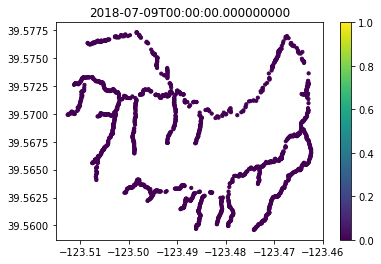

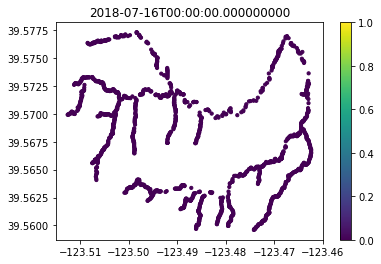

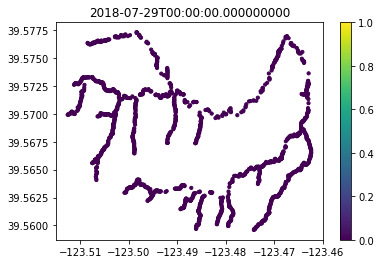

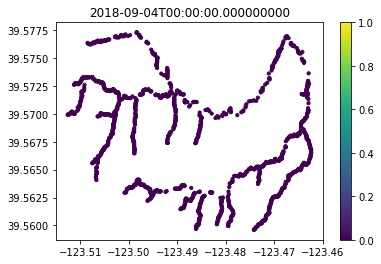

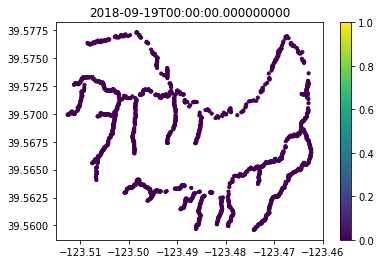

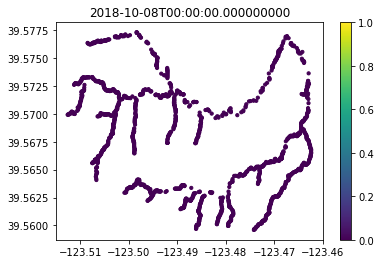

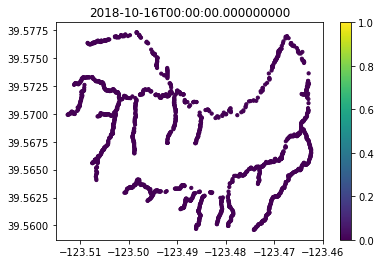

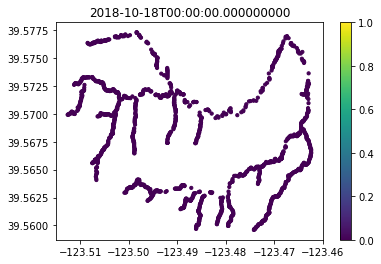

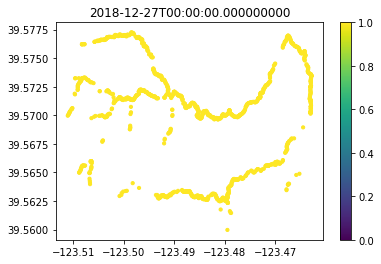

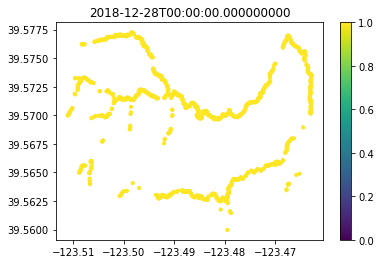

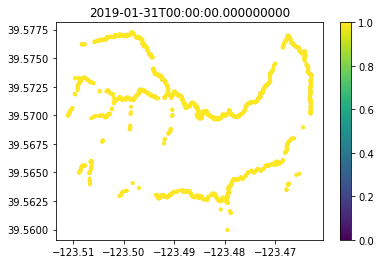

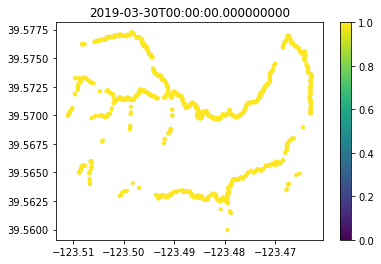

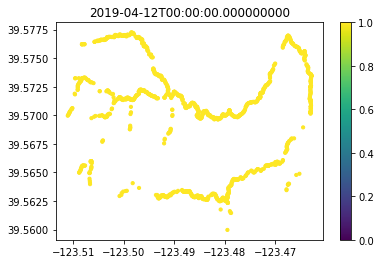

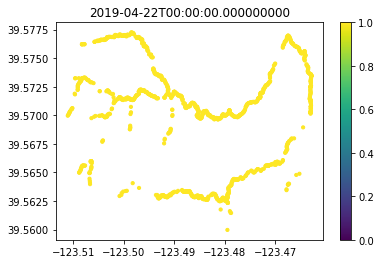

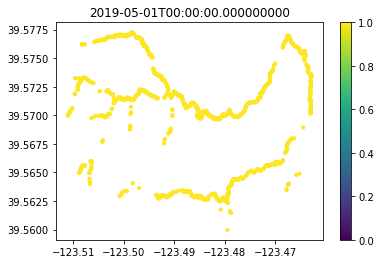

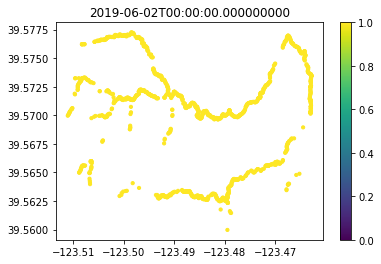

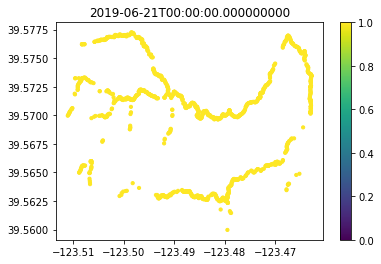

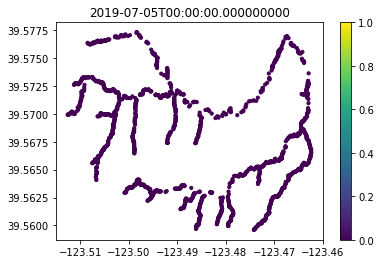

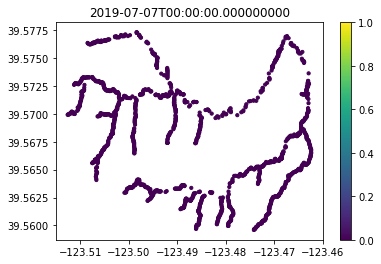

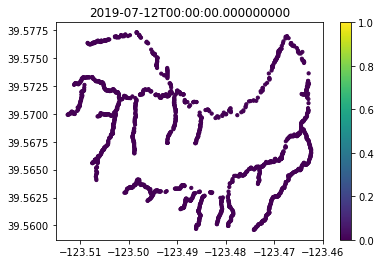

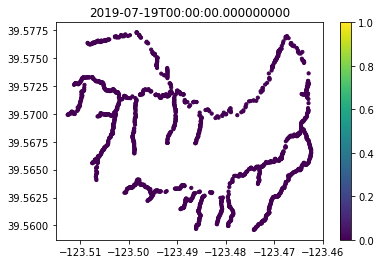

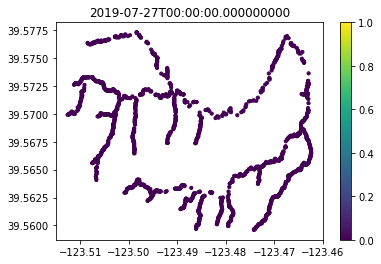

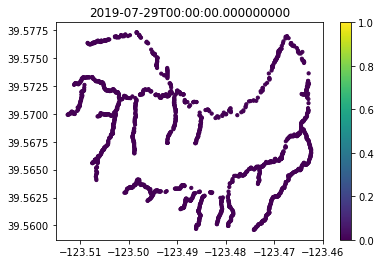

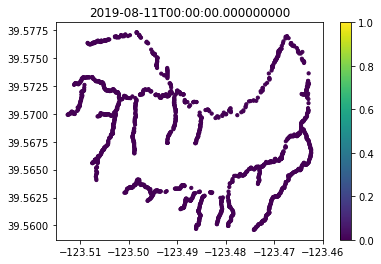

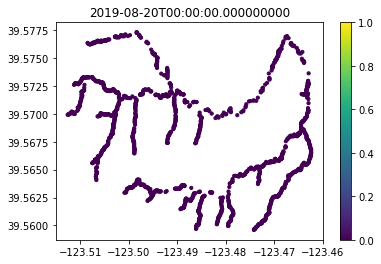

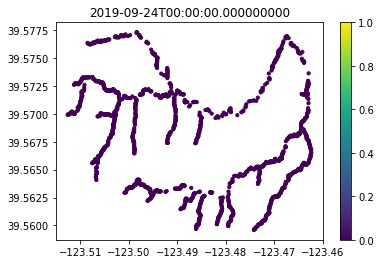

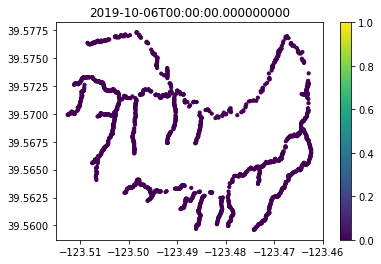

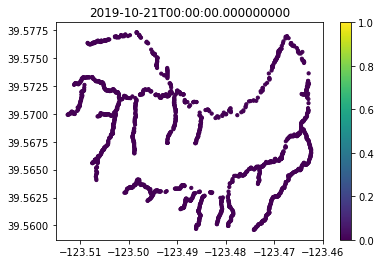

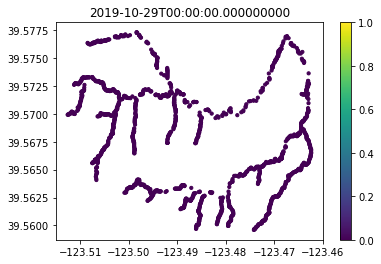

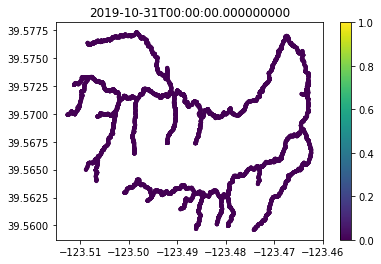

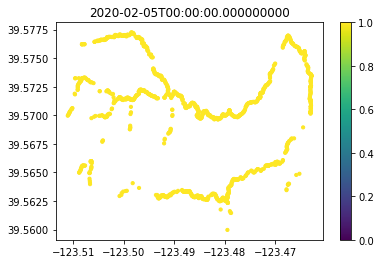

In [ ]:
added_data['date'] = pd.to_datetime(added_data.date)

%matplotlib inline
for date in added_data.date.sort_values().unique():
  plotdata = added_data[(added_data.date==date) &
                        (added_data.area_updated>100000)]
  plt.figure()
  plt.scatter(plotdata.x,plotdata.y,c=plotdata.wet,vmin=0,vmax=1,
              s = 10)
  plt.colorbar()
  plt.title(date)
  plt.show()